In [2]:
!pip install mediapipe opencv-python

In [4]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Ruta al dataset (ajusta según tu dataset de Kaggle)
dataset_path = "/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train"

In [9]:
import cv2
import mediapipe as mp

# Inicializa MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

input_folder = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train'
output_folder = 'asl_alphabet_train_cropped'

os.makedirs(output_folder, exist_ok=True)

for label in os.listdir(input_folder):
    label_folder = os.path.join(input_folder, label)
    output_label_folder = os.path.join(output_folder, label)
    os.makedirs(output_label_folder, exist_ok=True)

    for image_name in os.listdir(label_folder):
        image_path = os.path.join(label_folder, image_name)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            # Encuentra el bounding box de la mano
            h, w, _ = image.shape
            x_min = w
            y_min = h
            x_max = 0
            y_max = 0

            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)

            # Ajusta el cuadro con un margen
            margin = 20
            x_min = max(x_min - margin, 0)
            y_min = max(y_min - margin, 0)
            x_max = min(x_max + margin, w)
            y_max = min(y_max + margin, h)

            hand_crop = image[y_min:y_max, x_min:x_max]
            output_path = os.path.join(output_label_folder, image_name)
            cv2.imwrite(output_path, hand_crop)


W0000 00:00:1751237420.226627     135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751237420.254415     135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


KeyboardInterrupt: 

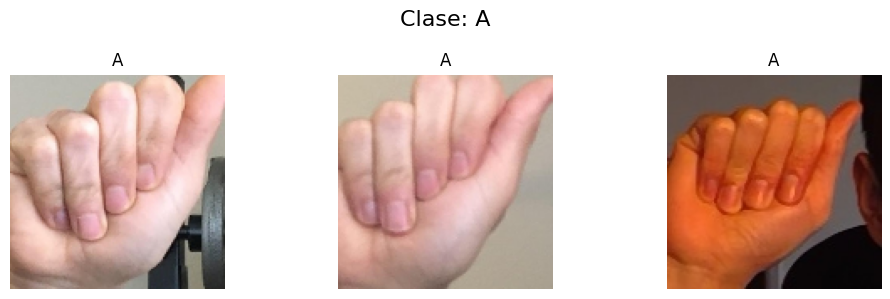

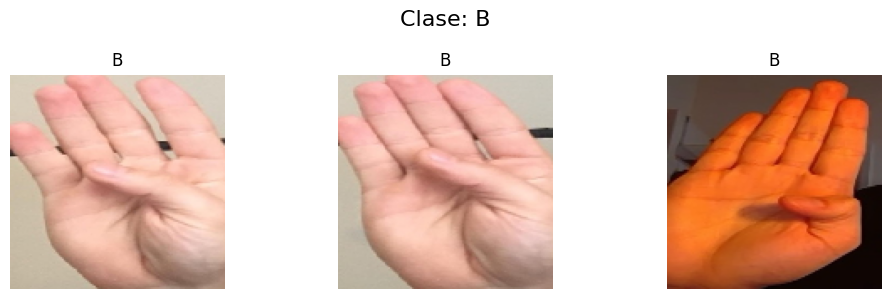

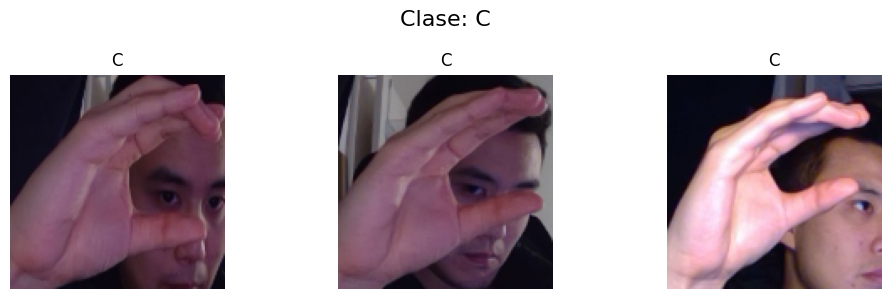

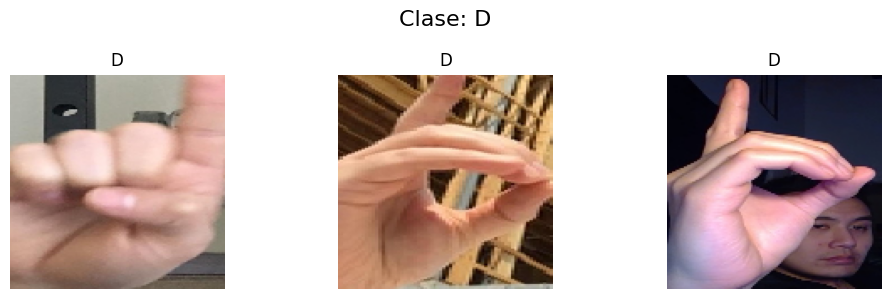

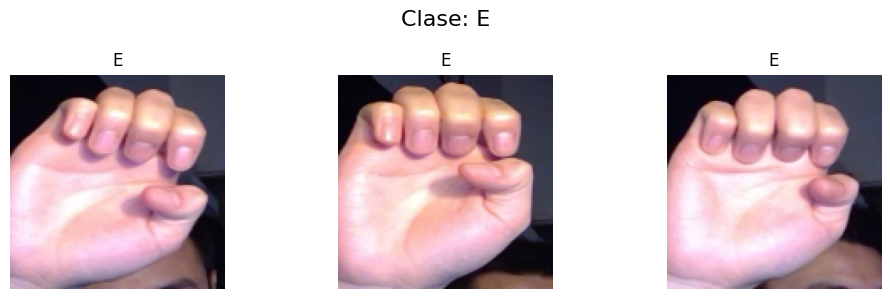

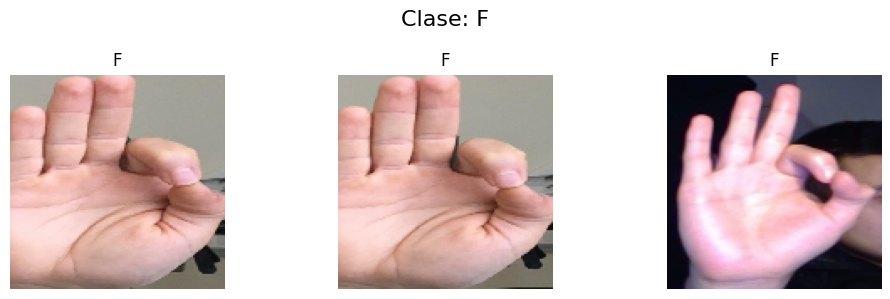

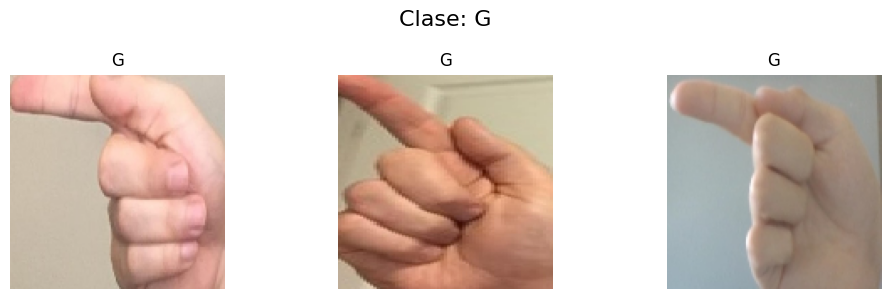

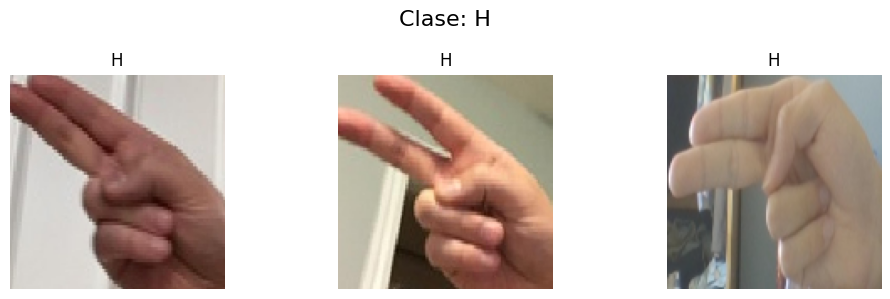

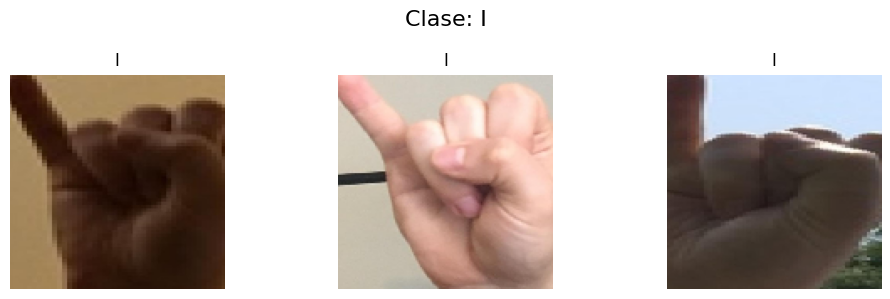

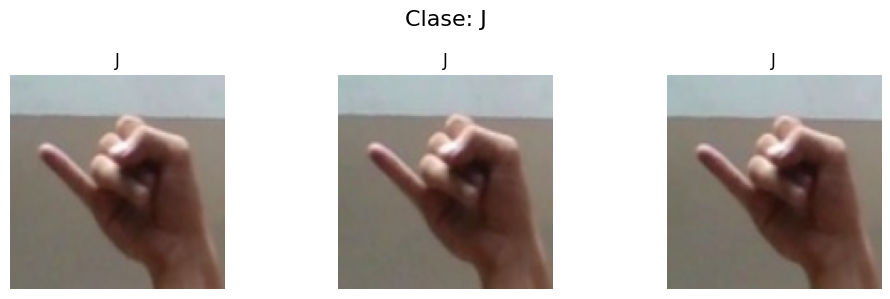

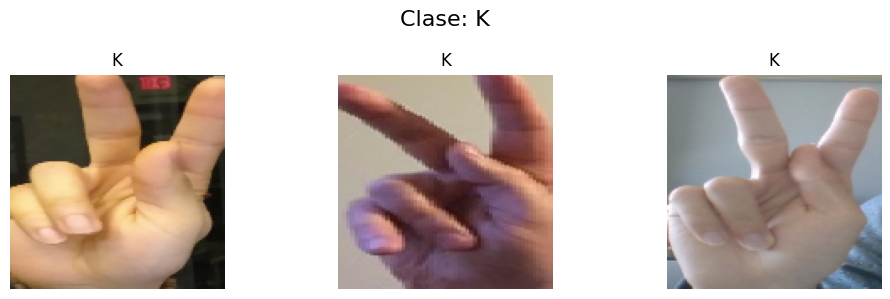

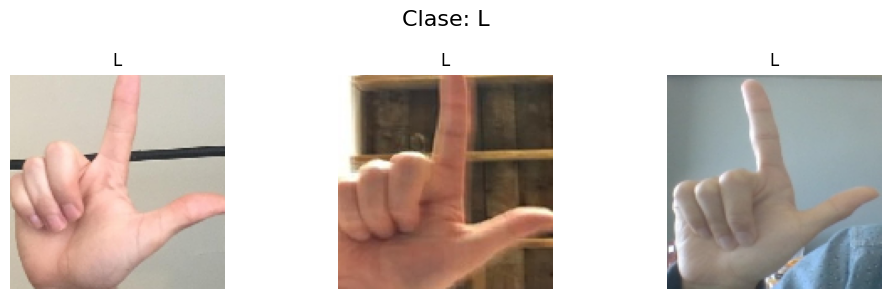

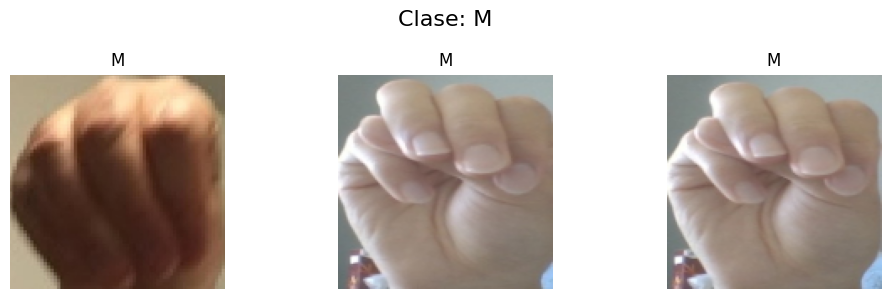

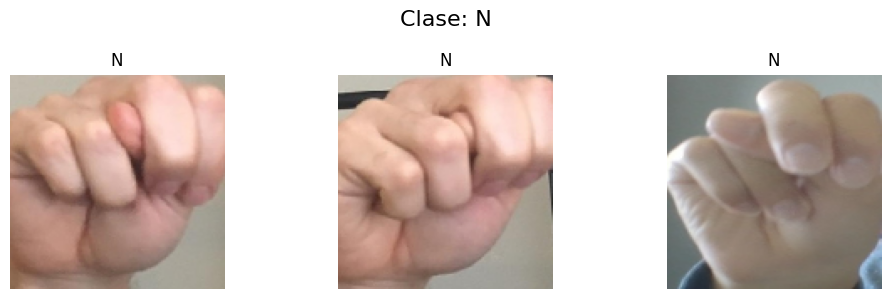

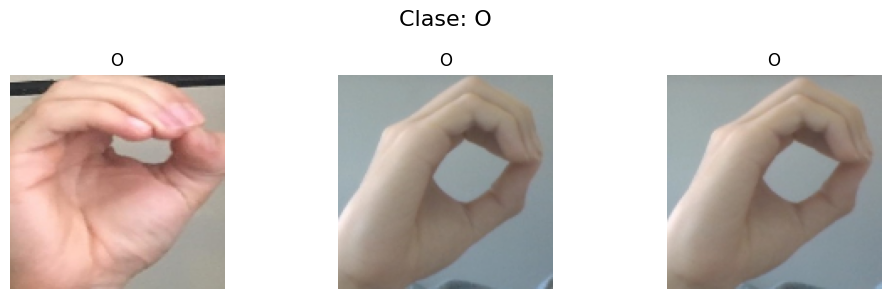

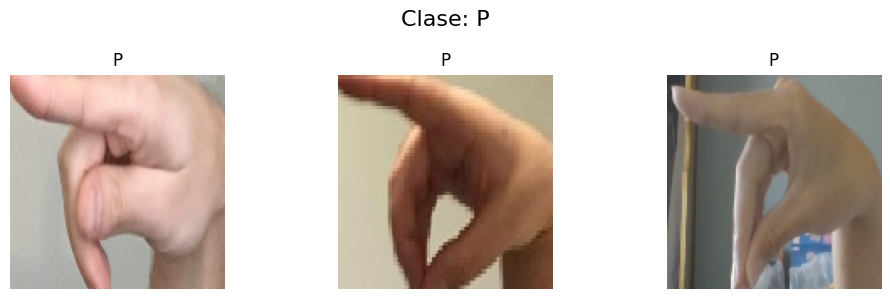

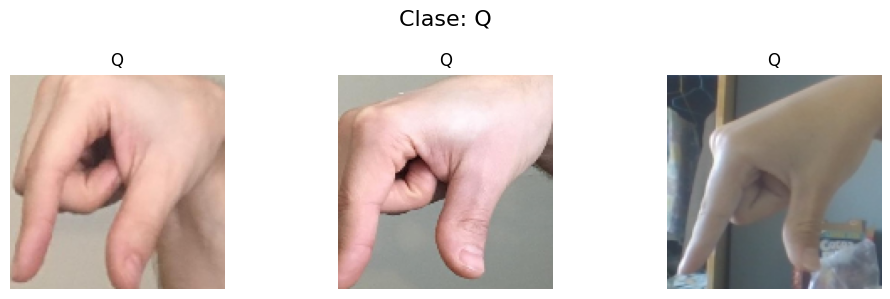

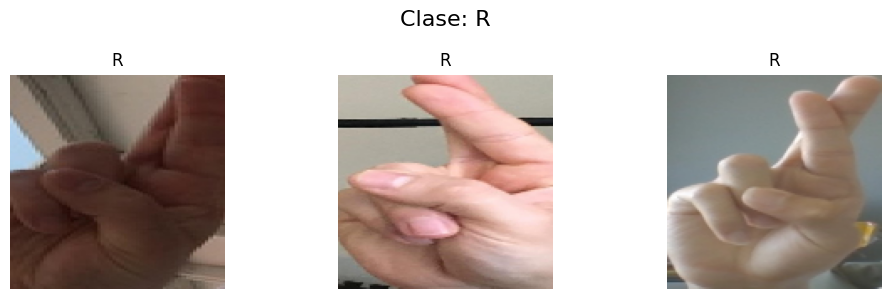

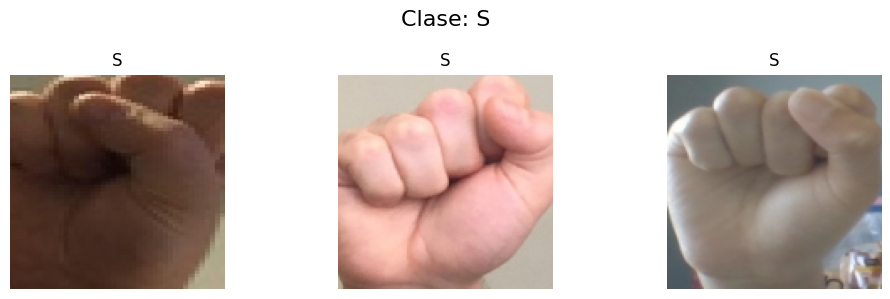

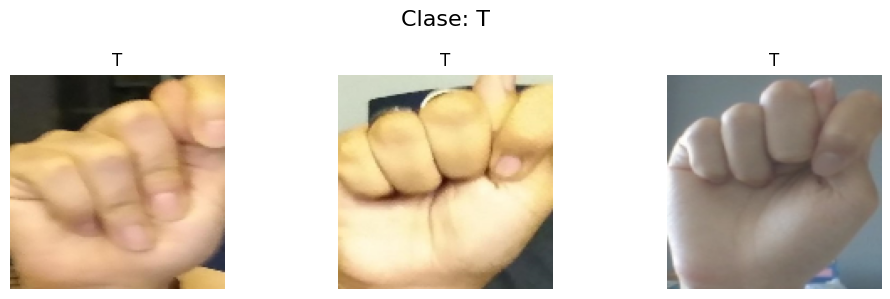

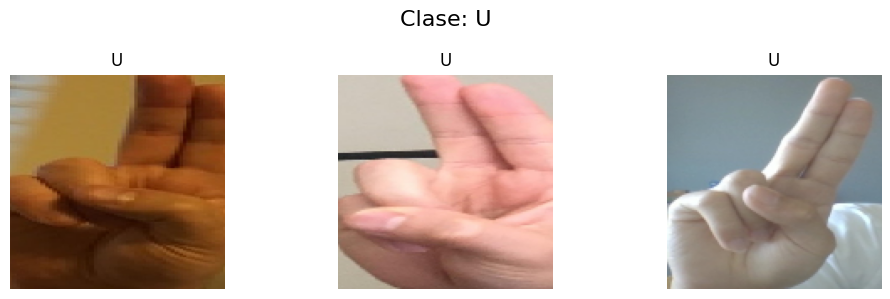

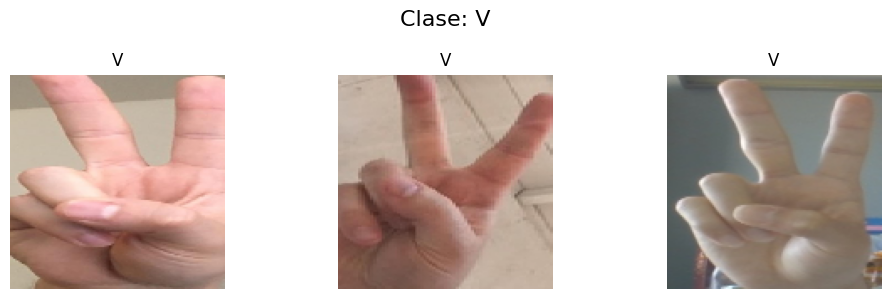

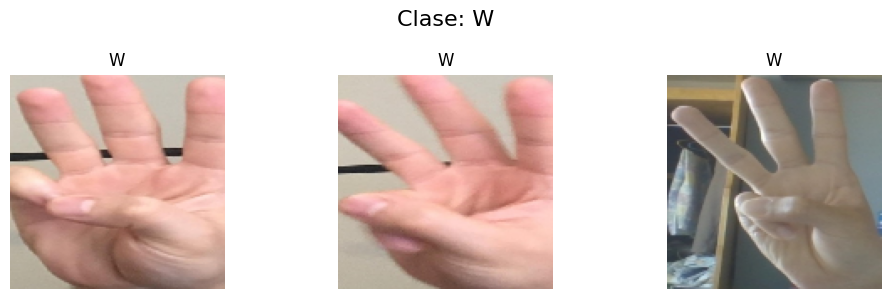

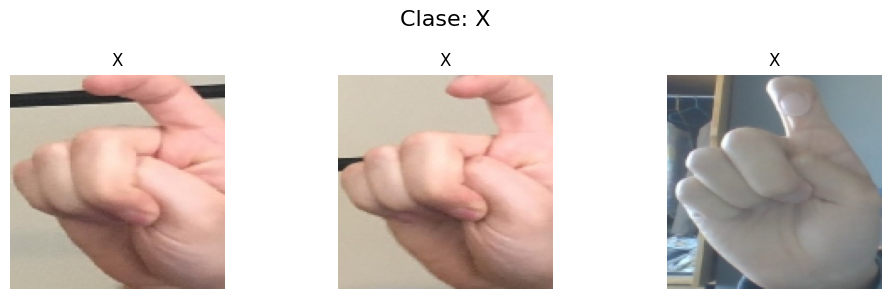

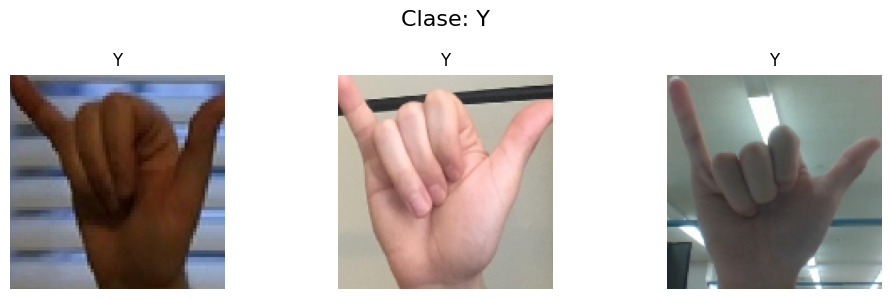

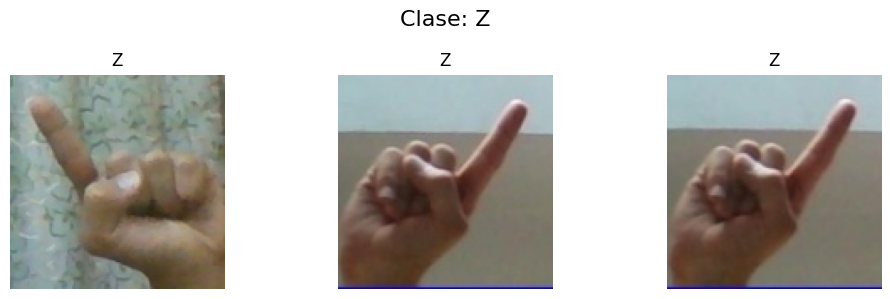

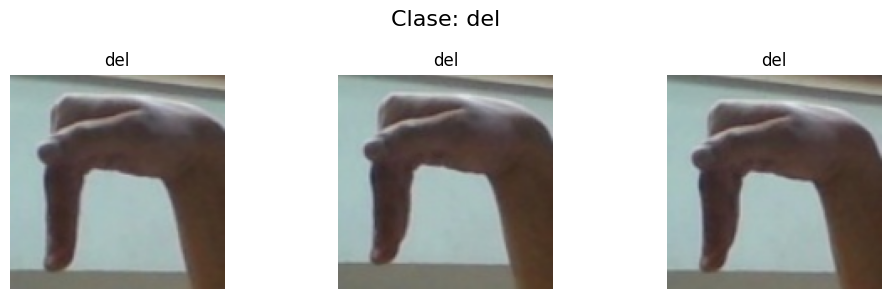

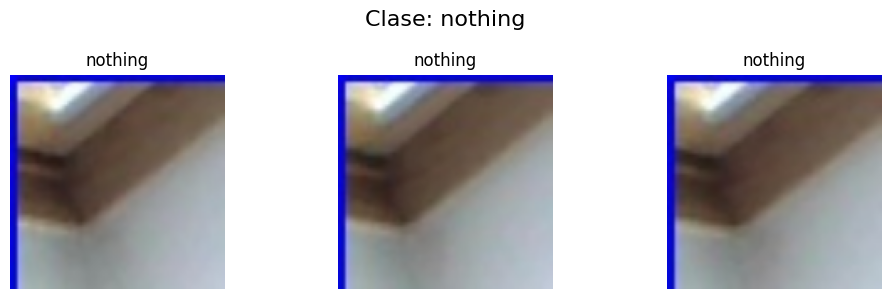

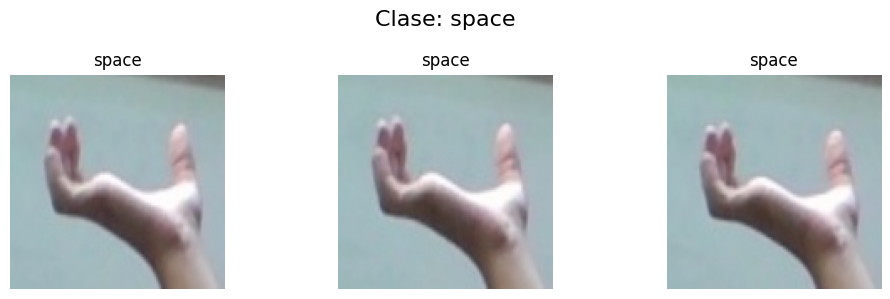

In [10]:
import os
import matplotlib.pyplot as plt
import cv2

DATASET_DIR = '/kaggle/working/asl_alphabet_train_cropped'
IMAGE_SIZE = (128, 128)  # o 224x224 si lo prefieres para ver cómo entra al modelo

classes = sorted(os.listdir(DATASET_DIR))

for cls in classes:
    class_dir = os.path.join(DATASET_DIR, cls)
    image_files = sorted(os.listdir(class_dir))[:3]  # Solo las 3 primeras

    plt.figure(figsize=(10, 3))
    for i, image_name in enumerate(image_files):
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f'{cls}')
        plt.axis('off')

    plt.suptitle(f'Clase: {cls}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [13]:
import os
import shutil
import random
from tqdm import tqdm

# Rutas y parámetros
ORIGINAL_DATASET = 'asl_alphabet_train_cropped'
TARGET_DATASET = 'asl_dataset'
TRAIN_DIR = os.path.join(TARGET_DATASET, 'train')
VAL_DIR = os.path.join(TARGET_DATASET, 'val')
SPLIT_RATIO = 0.8

# Crear carpetas de destino
for folder in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(folder, exist_ok=True)

# Recorrer cada clase
for class_name in tqdm(os.listdir(ORIGINAL_DATASET), desc="Dividiendo clases"):
    class_path = os.path.join(ORIGINAL_DATASET, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_index = int(len(images) * SPLIT_RATIO)
    train_images = images[:split_index]
    val_images = images[split_index:]

    train_class_dir = os.path.join(TRAIN_DIR, class_name)
    val_class_dir = os.path.join(VAL_DIR, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in train_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(train_class_dir, img))

    for img in val_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(val_class_dir, img))


Dividiendo clases: 100%|██████████| 29/29 [00:15<00:00,  1.88it/s]


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Parámetros
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
TRAIN_PATH = 'asl_dataset/train'
VAL_PATH = 'asl_dataset/val'
NUM_CLASSES = len(os.listdir(TRAIN_PATH))

# Generadores
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Modelo base
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Capa superior
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilación y entrenamiento
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Found 121950 images belonging to 29 classes.
Found 30499 images belonging to 29 classes.
Epoch 1/10
3811/3811 ━━━━━━━━━━━━━━━━━━━━ 169s 43ms/step - accuracy: 0.7892 - loss: 0.7680 - val_accuracy: 0.9532 - val_loss: 0.1785
Epoch 2/10
3811/3811 ━━━━━━━━━━━━━━━━━━━━ 155s 41ms/step - accuracy: 0.9307 - loss: 0.2341 - val_accuracy: 0.9607 - val_loss: 0.1395
Epoch 3/10
3811/3811 ━━━━━━━━━━━━━━━━━━━━ 156s 41ms/step - accuracy: 0.9385 - loss: 0.2029 - val_accuracy: 0.9702 - val_loss: 0.1151
Epoch 4/10
3811/3811 ━━━━━━━━━━━━━━━━━━━━ 168s 44ms/step - accuracy: 0.9408 - loss: 0.1922 - val_accuracy: 0.9671 - val_loss: 0.1164
Epoch 5/10
3811/3811 ━━━━━━━━━━━━━━━━━━━━ 160s 42ms/step - accuracy: 0.9433 - loss: 0.1841 - val_accuracy: 0.9704 - val_loss: 0.1089
Epoch 6/10
3811/3811 ━━━━━━━━━━━━━━━━━━━━ 156s 41ms/step - accuracy: 0.9462 - loss: 0.1748 - val_accuracy: 0.9748 - val_loss: 0.0951
Epoch 7/10
3811/3811 ━━━━━━━━━━━━━━━━━━━━ 156s 41ms/step - accuracy: 0.9461 - loss: 0.1765 - val_accuracy: 0.9746

In [15]:
model.save('/kaggle/working/asl_model.h5')